In [42]:
import pandas as pd
import requests
import bs4 as bs
import os
from urllib.parse import urljoin
from tqdm import tqdm
import multiprocess as mp
import glob
import numpy as np
import matplotlib.pyplot as plt
import shutil
import splitfolders

MAX_WORKERS = 1

# Retrieve european bird species dataframe

In [2]:
url = 'https://www.oiseaux.net/oiseaux/france.html'
page = requests.get(url)
break_code = 'XXXXXXXXXX'
page_text = page.text.replace('<br />', break_code)

soup = bs.BeautifulSoup(page_text, 'lxml')
parsed_table = soup.find_all('table')[0]

data = []
for row in parsed_table.find_all('tr'):
    row_data = []
    id = None
    for td in row.find_all('td'):
        if id is None: # Called once: get only id of french tag
            id = ''
            if td.find('a'):
                id = td.a['href'].split('/')[-1].replace('.html', '')
        # Retain only main name by skipping row after break code
        row_data.append(''.join(td.stripped_strings).split('\n')[0])
    row_data.append(id)
    data.append(row_data)

fr_species_df = pd.DataFrame(data[1:], columns=['french', 'latin', 'english', 'id'])

In [3]:
fr_species_df

,french,latin,english,id
0,Accenteur à gorge noire,Prunella atrogularis,Black-throated Accentor,accenteur.a.gorge.noire
1,Accenteur alpin,Prunella collaris,Alpine Accentor,accenteur.alpin
2,Accenteur mouchet,Prunella modularis,Dunnock,accenteur.mouchet
3,Agrobate roux,Cercotrichas galactotes,Rufous-tailed Scrub Robin,agrobate.roux
4,Aigle botté,Hieraaetus pennatus,Booted Eagle,aigle.botte
...,...,...,...,...
623,Vautour oricou,Torgos tracheliotos,Lappet-faced Vulture,vautour.oricou
624,Venturon corse,Carduelis corsicana,Corsican Finch,venturon.corse
625,Venturon montagnard,Carduelis citrinella,Citril Finch,venturon.montagnard
626,Verdier d'Europe,Chloris chloris,European Greenfinch,verdier.d.europe


# Scrap images of each european bird species

In [4]:
dataset_file_root = 'fr_birds'
os.makedirs(dataset_file_root, exist_ok=True)

In [5]:
photos_url_template = 'https://www.oiseaux.net/oiseaux/photos/%s.html'

In [6]:
def download_images(url, dest, count):
    r = requests.get(url)
    soup = bs.BeautifulSoup(r.text, 'html.parser')
    figures = soup.find_all('figure')
    for figure in figures:
        href = figure.a['href']
        photo_page_url = urljoin(url, href)

        r = requests.get(photo_page_url)
        soup = bs.BeautifulSoup(r.text, 'html.parser')
        image_src = soup.figure.img['src']
        image_url = urljoin(photo_page_url, f'{image_src}')

        r = requests.get(image_url).content
        with open(f"{dest}/{count}.jpg", "wb+") as f:
            f.write(r)
            count += 1
    return count

In [7]:
def scrap_species_images(species_entry):
    species_fr_name = species_entry[0] # french column
    species_folder = f'{dataset_file_root}/{species_fr_name}'
    os.makedirs(species_folder, exist_ok=True)

    species_photos_url = photos_url_template % species_entry[-1] # id column
    try:
        count = 0
        for i in range(1, 100):
            if i != 1:
                replace_string = '.html'
                if i >= 3:
                    replace_string = f'.{i - 1}.html'
                species_photos_url = species_photos_url.replace(replace_string, f'.{i}.html')
            response = requests.get(species_photos_url)
            if response.url == 'https://www.oiseaux.net/erreur/index.html':
                break
            count = download_images(species_photos_url, species_folder, count)
    except:
        print(f'An exception has occured for species: {species_entry}')

In [8]:
# with mp.Pool(processes=MAX_WORKERS) as pool:
for species in tqdm(fr_species_df.to_numpy(), total=len(fr_species_df.to_numpy())):
    scrap_species_images(species)
        # for result in results: pass

 27%|██▋       | 172/628 [4:06:12<11:00:17, 86.88s/it] 

An exception has occured for species: ['Damier du Cap' 'Daption capense' 'Cape Petrel' 'damier.du.cap']


100%|██████████| 628/628 [14:11:53<00:00, 81.39s/it]   


In [41]:
!tar cf fr_birds.tar fr_birds/

# Clean and prepare dataset

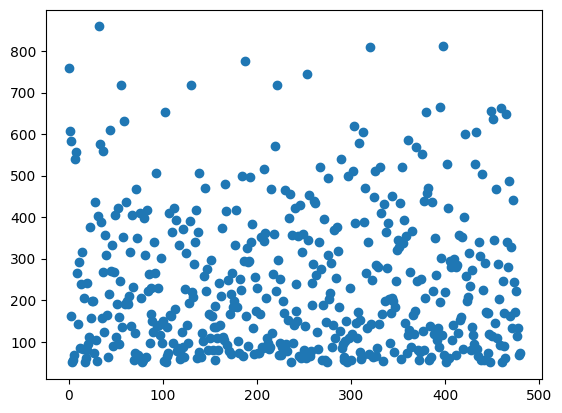

In [40]:
species_folders = glob.glob('fr_birds/*')
x = np.arange(len(species_folders))
y = []

for species in species_folders:
    nb_images = len(glob.glob(f'{species}/*'))
    y.append(nb_images)

plt.scatter(x, y)

In [43]:
splitfolders.ratio("fr_birds", output="fr_birds_dataset",
    seed=42, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 117121 files [00:55, 2099.15 files/s]


In [65]:
def int_approx_equal(a, b):
    if a > b:
        a, b = b, a
    return a >= int(b * 0.85) and a <= int(b * 1.15)

In [66]:
for train_species_folder in glob.glob('fr_birds_dataset/train/*'):
    species_name = train_species_folder.split('/')[-1]

    nb_images = {
        key: len(glob.glob(f'fr_birds_dataset/{key}/{species_name}/*')) for key in ['train', 'val', 'test']
    }

    total = nb_images['train'] + nb_images['val'] + nb_images['test']

    assert int_approx_equal(nb_images['train'], int(0.8 * total)) \
        and int_approx_equal(nb_images['val'], int(0.1 * total)) \
        and int_approx_equal(nb_images['test'], int(0.1 * total))

In [67]:
!tar cf fr_birds_dataset.tar fr_birds_dataset/